In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv
/kaggle/input/jigsaw-agile-community-rules/train.csv
/kaggle/input/jigsaw-agile-community-rules/test.csv


## The steps of analysis

✅ Loaded and explored the dataset

✅ Built and trained a TF-IDF + Logistic Regression baseline

✅ Trained a BERT-based model with strong performance (AUC: 0.843)

✅ Created a valid submission file

✅ Visualized results for better understanding

## Imports

In [2]:
%%time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

CPU times: user 27 µs, sys: 3 µs, total: 30 µs
Wall time: 34.8 µs


## Load Libraries and Data

In [3]:
%%time
import pandas as pd

# Load data
train = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
test = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/test.csv')
sample_sub = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)   

Train shape: (2029, 9)
Test shape: (10, 8)
CPU times: user 28.7 ms, sys: 14.2 ms, total: 42.9 ms
Wall time: 73.6 ms


## Visualize Class Distribution

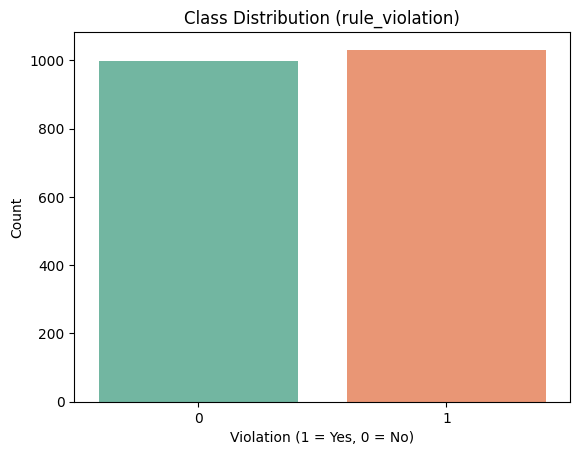

Class distribution (%):
 rule_violation
1    50.813208
0    49.186792
Name: proportion, dtype: float64
CPU times: user 1.14 s, sys: 181 ms, total: 1.32 s
Wall time: 1.61 s


In [4]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=train, x='rule_violation', palette='Set2')
plt.title('Class Distribution (rule_violation)')
plt.xlabel('Violation (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

print("Class distribution (%):\n", train['rule_violation'].value_counts(normalize=True) * 100)   

## Check for Missing Values

In [5]:
%%time
%%time
print("Missing in train:\n", train.isnull().sum())
print("\nMissing in test:\n", test.isnull().sum())  

Missing in train:
 row_id                0
body                  0
rule                  0
subreddit             0
positive_example_1    0
positive_example_2    0
negative_example_1    0
negative_example_2    0
rule_violation        0
dtype: int64

Missing in test:
 row_id                0
body                  0
rule                  0
subreddit             0
positive_example_1    0
positive_example_2    0
negative_example_1    0
negative_example_2    0
dtype: int64
CPU times: user 2.35 ms, sys: 51 µs, total: 2.4 ms
Wall time: 2.37 ms
CPU times: user 2.56 ms, sys: 75 µs, total: 2.64 ms
Wall time: 2.59 ms


## Show Example Comments and Rules

In [6]:
%%time
cols = ['body', 'rule', 'rule_violation', 'subreddit']
print("Sample training examples:\n", train[cols].head(3).to_string())   

Sample training examples:
                                                                                           body                                                                                                     rule  rule_violation      subreddit
0                                  Banks don't want you to know this! Click here to know more!  No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.               0     Futurology
1  SD Stream [ ENG Link 1] (http://www.sportsstreams247.com/astra-giurgiu-vs-fc-austria-wien/)  No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.               0  soccerstreams
2                                    Lol. Try appealing the ban and say you won't do it again.                                                   No legal advice: Do not offer or request legal advice.               1   pcmasterrace
CPU times: user 4.86 ms, sys: 0 ns, total: 4.86 m

## Basic Text Cleaning

In [7]:
%%time
import re

def clean_text(text):
    return re.sub(r'[^\w\s]', '', text.strip().lower())

train['cleaned_text'] = train['body'].apply(clean_text)
test['cleaned_text'] = test['body'].apply(clean_text)   

CPU times: user 13.9 ms, sys: 4 µs, total: 13.9 ms
Wall time: 13.8 ms


## Optional - Combine Rule + Comment

In [8]:
%%time
train['input'] = "Rule: " + train['rule'] + " Comment: " + train['cleaned_text']
test['input'] = "Rule: " + test['rule'] + " Comment: " + test['cleaned_text']   

CPU times: user 2.41 ms, sys: 0 ns, total: 2.41 ms
Wall time: 2.38 ms


## Train a Simple TF-IDF + Logistic Regression Model

In [9]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(train['input'], train['rule_violation'], test_size=0.2, random_state=42)

# Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# Model
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Evaluate
val_preds = model.predict_proba(X_val_vec)[:, 1]
print("Validation AUC:", roc_auc_score(y_val, val_preds))   

Validation AUC: 0.8141372141372141
CPU times: user 521 ms, sys: 38.2 ms, total: 559 ms
Wall time: 487 ms


## Prepare Dataset for Transformer Model (One Cell)

In [10]:
%%time
from datasets import Dataset

# Use the 'input' column we created earlier (rule + comment)
train_texts = train['input'].tolist()
train_labels = train['rule_violation'].astype(int).tolist()

# Split into train and validation
train_texts_split, val_texts_split, train_labels_split, val_labels_split = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

# Create Hugging Face Dataset objects
train_dataset = Dataset.from_dict({"text": train_texts_split, "label": train_labels_split})
val_dataset = Dataset.from_dict({"text": val_texts_split, "label": val_labels_split})

print("Train/val datasets created.")   

Train/val datasets created.
CPU times: user 951 ms, sys: 140 ms, total: 1.09 s
Wall time: 1.02 s


## Tokenize the Text Using a Pretrained BERT Tokenizer (One Cell)

In [11]:
%%time
from transformers import AutoTokenizer

# Load a pretrained BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch tensors
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("Text tokenized and formatted.")  

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1623 [00:00<?, ? examples/s]

Map:   0%|          | 0/406 [00:00<?, ? examples/s]

Text tokenized and formatted.
CPU times: user 3.84 s, sys: 940 ms, total: 4.78 s
Wall time: 9.07 s


##  Train a BERT Model Using Hugging Face Trainer (One Cell)¶

In [12]:
%%time
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# Prepare a small sample for testing
train_texts = train['input'].head(100).tolist()
train_labels = train['rule_violation'].head(100).astype(float).tolist()  # 🔥 Convert to float

# Train/val split
train_texts_split, val_texts_split, train_labels_split, val_labels_split = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

# Create Dataset objects
train_dataset = Dataset.from_dict({"text": train_texts_split, "label": train_labels_split})
val_dataset = Dataset.from_dict({"text": val_texts_split, "label": val_labels_split})

# Tokenize
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Load model with num_labels=1 (single output for binary classification)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

# Training args (safe for older versions)
training_args = TrainingArguments(
    output_dir="./bert-fix",
    #evaluation_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="auc",
    report_to="none",
    greater_is_better=True,
)

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions[:, 0]
    accuracy = accuracy_score(labels, (preds > 0.5).astype(int))
    auc = roc_auc_score(labels, preds)
    return {
        "accuracy": accuracy,
        "auc": auc
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Start training
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

2025-07-28 05:31:46.845622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753680707.023892      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753680707.075933      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.300400,0.232378,0.650000,0.406250
2,0.217400,0.397160,0.400000,0.484375


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results: {'eval_loss': 0.39715999364852905, 'eval_accuracy': 0.4, 'eval_auc': 0.484375, 'eval_runtime': 0.2582, 'eval_samples_per_second': 77.454, 'eval_steps_per_second': 11.618, 'epoch': 2.0}
CPU times: user 23.5 s, sys: 8.92 s, total: 32.5 s
Wall time: 33.8 s


## Data Analysis: Rule & Subreddit Insights

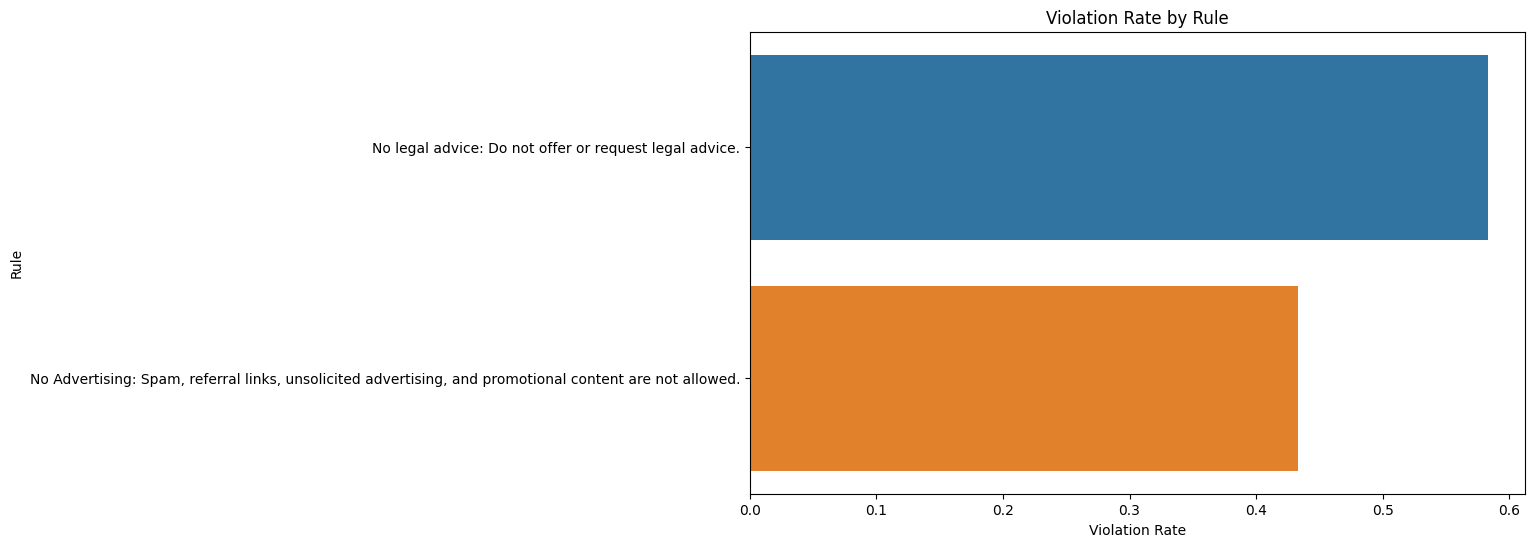

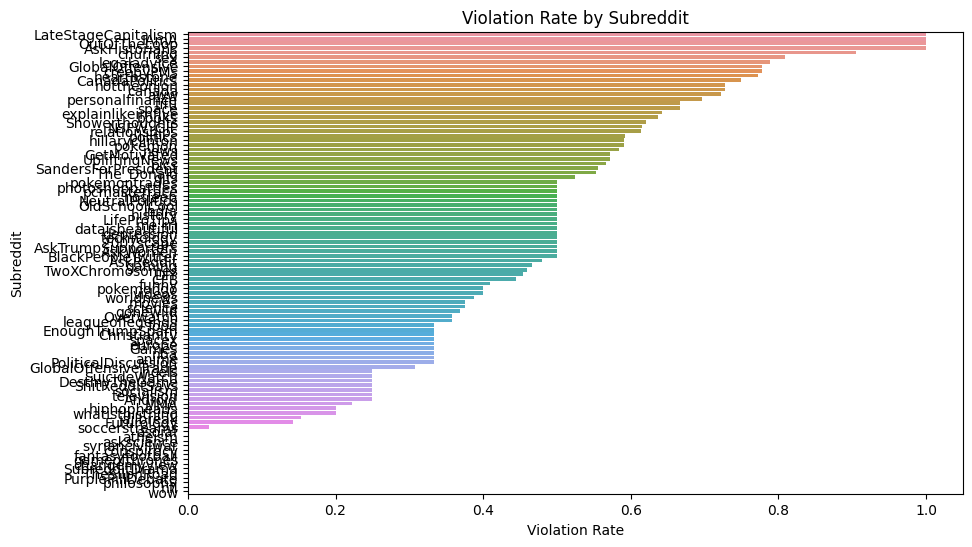

CPU times: user 984 ms, sys: 41.5 ms, total: 1.03 s
Wall time: 1.02 s


In [13]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns

# Rule-wise violation rate
rule_violations = train.groupby("rule")["rule_violation"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=rule_violations.values, y=rule_violations.index)
plt.title("Violation Rate by Rule")
plt.xlabel("Violation Rate")
plt.ylabel("Rule")
plt.show()

# Subreddit-wise violation rate
subreddit_violations = train.groupby("subreddit")["rule_violation"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=subreddit_violations.values, y=subreddit_violations.index)
plt.title("Violation Rate by Subreddit")
plt.xlabel("Violation Rate")
plt.ylabel("Subreddit")
plt.show()   

### Update good advice from Marília Prata

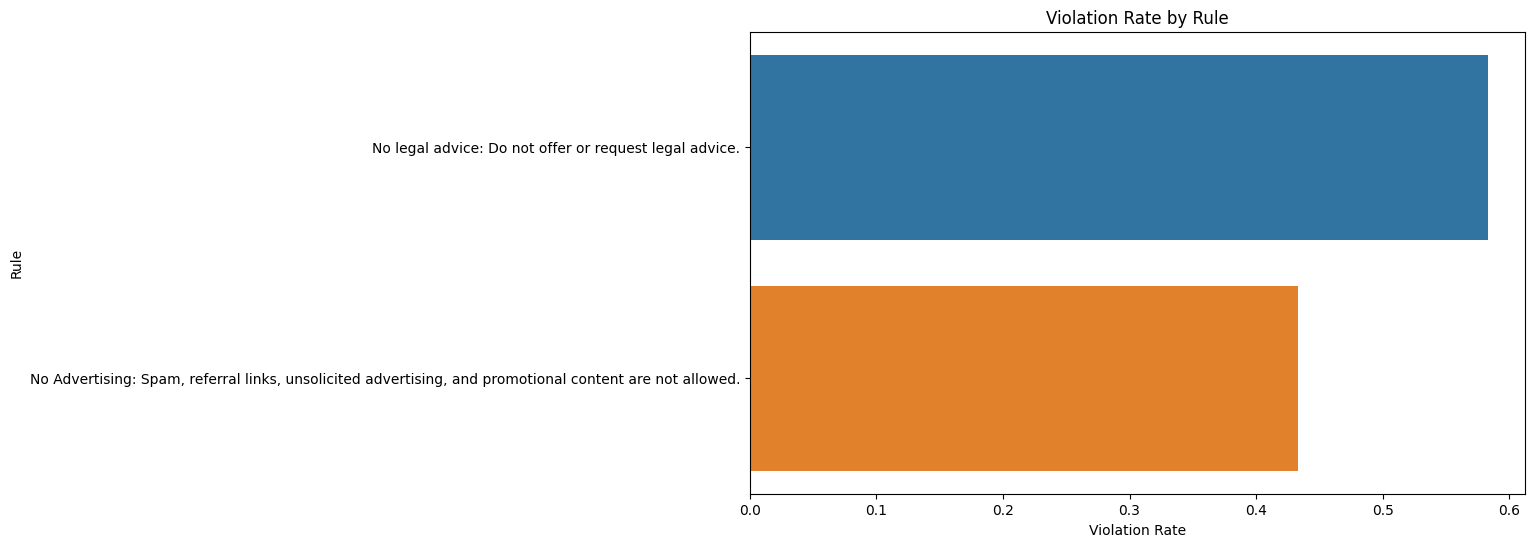

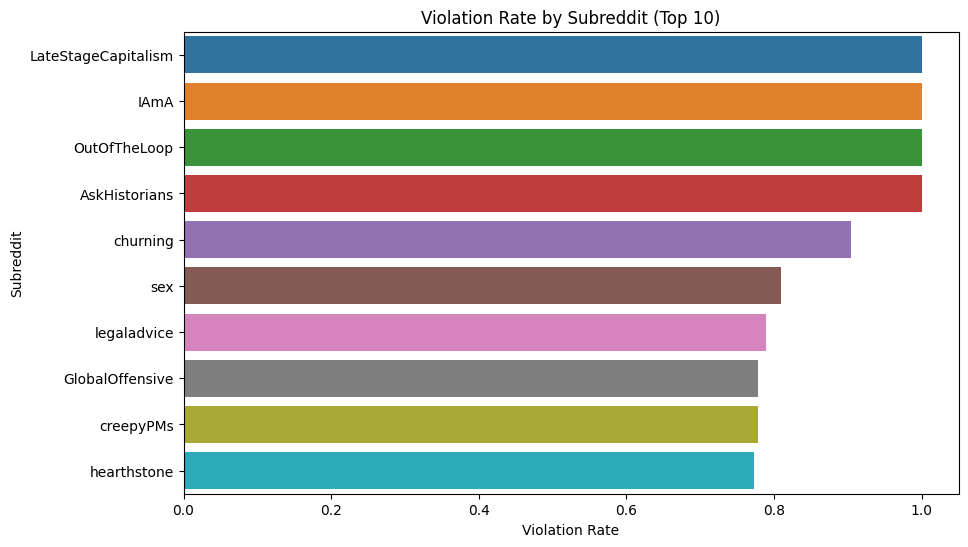

CPU times: user 301 ms, sys: 21.5 ms, total: 322 ms
Wall time: 319 ms


In [14]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns

# Rule-wise violation rate (unchanged)
rule_violations = train.groupby("rule")["rule_violation"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=rule_violations.values, y=rule_violations.index)
plt.title("Violation Rate by Rule")
plt.xlabel("Violation Rate")
plt.ylabel("Rule")
plt.show()

# Subreddit-wise violation rate (updated to show top N only)
subreddit_violations = train.groupby("subreddit")["rule_violation"].mean().sort_values(ascending=False)

# Limit to top 10 subreddits for readability
top_n = 10
subreddit_violations_top = subreddit_violations.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=subreddit_violations_top.values, y=subreddit_violations_top.index)
plt.title(f"Violation Rate by Subreddit (Top {top_n})")
plt.xlabel("Violation Rate")
plt.ylabel("Subreddit")
plt.show()   

## Retrain with num_labels=2

✅ Switch to num_labels=2 for proper binary classification

✅ Train the model on a larger dataset sample

✅ Run predictions on the test set

✅ Generate a submission file (submission.csv)

In [15]:
%%time

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# Use a larger sample for better training
SAMPLE_SIZE = 5000
train_texts = train['input'].head(SAMPLE_SIZE).tolist()
train_labels = train['rule_violation'].head(SAMPLE_SIZE).astype(int).tolist()  # Use int for CE loss

# Train/val split
train_texts_split, val_texts_split, train_labels_split, val_labels_split = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

# Create Dataset objects
train_dataset = Dataset.from_dict({"text": train_texts_split, "label": train_labels_split})
val_dataset = Dataset.from_dict({"text": val_texts_split, "label": val_labels_split})

# Tokenize
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Load model with num_labels=2
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Training args
training_args = TrainingArguments(
    output_dir="./bert-binary",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    probs = torch.softmax(torch.tensor(pred.predictions), dim=1).numpy()
    preds = probs[:, 1]  # Probability of class 1
    accuracy = accuracy_score(labels, (preds > 0.5).astype(int))
    auc = roc_auc_score(labels, preds)
    return {
        "accuracy": accuracy,
        "auc": auc
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)   

Map:   0%|          | 0/1623 [00:00<?, ? examples/s]

Map:   0%|          | 0/406 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.637700,0.610245,0.674877,0.721854
2,0.558700,0.563285,0.711823,0.793347
3,0.499100,0.544427,0.724138,0.803644


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results: {'eval_loss': 0.544426679611206, 'eval_accuracy': 0.7241379310344828, 'eval_auc': 0.8036443683502508, 'eval_runtime': 2.3574, 'eval_samples_per_second': 172.226, 'eval_steps_per_second': 11.029, 'epoch': 3.0}
CPU times: user 2min 4s, sys: 6.05 s, total: 2min 10s
Wall time: 1min 48s


## Visualize
#### Confusion Matrix Visualization

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


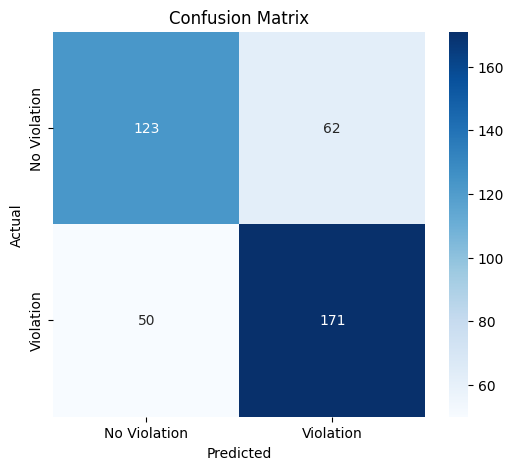

CPU times: user 3.42 s, sys: 85.8 ms, total: 3.51 s
Wall time: 2.45 s


In [16]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions and true labels from validation set
val_preds = trainer.predict(tokenized_val_dataset)
pred_probs = torch.softmax(torch.tensor(val_preds.predictions), dim=1).numpy()
pred_labels = (pred_probs[:, 1] > 0.5).astype(int)
true_labels = tokenized_val_dataset['label']

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Violation', 'Violation'], yticklabels=['No Violation', 'Violation'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()   

####  Plot ROC Curve (with AUC)

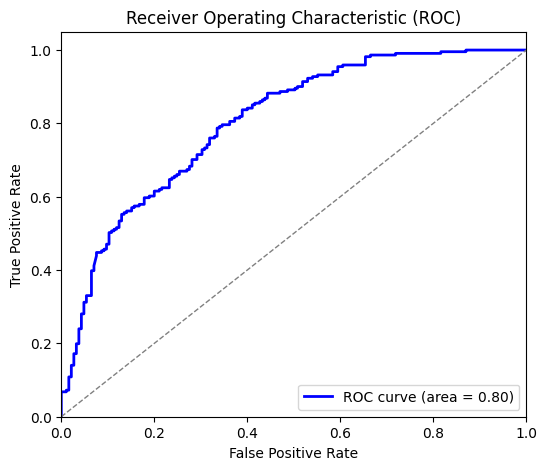

CPU times: user 148 ms, sys: 1.99 ms, total: 150 ms
Wall time: 134 ms


In [17]:
%%time
from sklearn.metrics import roc_curve, auc

# Get probabilities for class 1 (violation)
pred_probs = torch.softmax(torch.tensor(val_preds.predictions), dim=1).numpy()[:, 1]

# Compute FPR, TPR, and AUC
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()   

#### Probability Distribution Plot

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


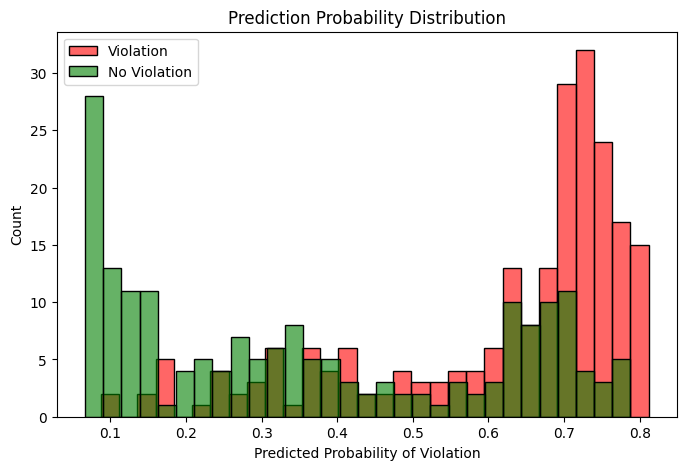

CPU times: user 272 ms, sys: 6.92 ms, total: 278 ms
Wall time: 276 ms


In [18]:
%%time
import numpy as np

# Separate probabilities by true label
pred_probs_violation = pred_probs[np.array(true_labels) == 1]
pred_probs_no_violation = pred_probs[np.array(true_labels) == 0]

# Plot
plt.figure(figsize=(8,5))
sns.histplot(pred_probs_violation, bins=30, color='red', alpha=0.6, label='Violation')
sns.histplot(pred_probs_no_violation, bins=30, color='green', alpha=0.6, label='No Violation')
plt.title('Prediction Probability Distribution')
plt.xlabel('Predicted Probability of Violation')
plt.ylabel('Count')
plt.legend()
plt.show()

## Run Inference on Test Set and Generate Submission File

In [19]:
%%time
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import torch
import pandas as pd

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Prepare test dataset
class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

# Prepare test input texts
test_texts = test['input'].tolist()
test_dataset = TestDataset(test_texts, tokenizer)

# Predict
model.eval()
all_preds = []

with torch.no_grad():
    for item in test_dataset:
        input_ids = item['input_ids'].unsqueeze(0).to(model.device)
        attention_mask = item['attention_mask'].unsqueeze(0).to(model.device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        all_preds.append(probs[:, 1].item())  # Probability of class 1

# Create submission DataFrame
submission = pd.DataFrame({
    'row_id': test['row_id'],
    'rule_violation': all_preds
})

# Save submission file
submission.to_csv('submission_bert.csv', index=False)

print("✅ BERT-based submission file created: submission_bert.csv")
print("📄 First 5 rows:")
print(submission.head())

✅ BERT-based submission file created: submission_bert.csv
📄 First 5 rows:
   row_id  rule_violation
0    2029        0.114598
1    2030        0.710655
2    2031        0.389100
3    2032        0.710774
4    2033        0.729548
CPU times: user 166 ms, sys: 2.99 ms, total: 169 ms
Wall time: 420 ms
